<a href="https://colab.research.google.com/github/dzagardo/17214-21fall-rec05/blob/main/Fairness_Recitation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!pip install aif360
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 8.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sklearn
sklearn.__version__

'1.0.2'

In [ ]:
#Load the libraries
import pandas as pd 
import numpy as np 

# For visualisation
import seaborn as sns 
import matplotlib.pyplot as plt 

Download the dataset from: https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk?resource=download

In [ ]:
df_credit = pd.read_csv("./german_credit_data.csv",index_col=0)
print(df_credit.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB
None


In [ ]:
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [ ]:
print("Purpose : ",df_credit.Purpose.unique())
print("Sex : ",df_credit.Sex.unique())
print("Housing : ",df_credit.Housing.unique())
print("Saving accounts : ",df_credit['Saving accounts'].unique())
print("Risk : ",df_credit['Risk'].unique())
print("Checking account : ",df_credit['Checking account'].unique())

Purpose :  ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
Sex :  ['male' 'female']
Housing :  ['own' 'free' 'rent']
Saving accounts :  [nan 'little' 'quite rich' 'rich' 'moderate']
Risk :  ['good' 'bad']
Checking account :  ['little' 'moderate' nan 'rich']


## Sex and Age Distribution

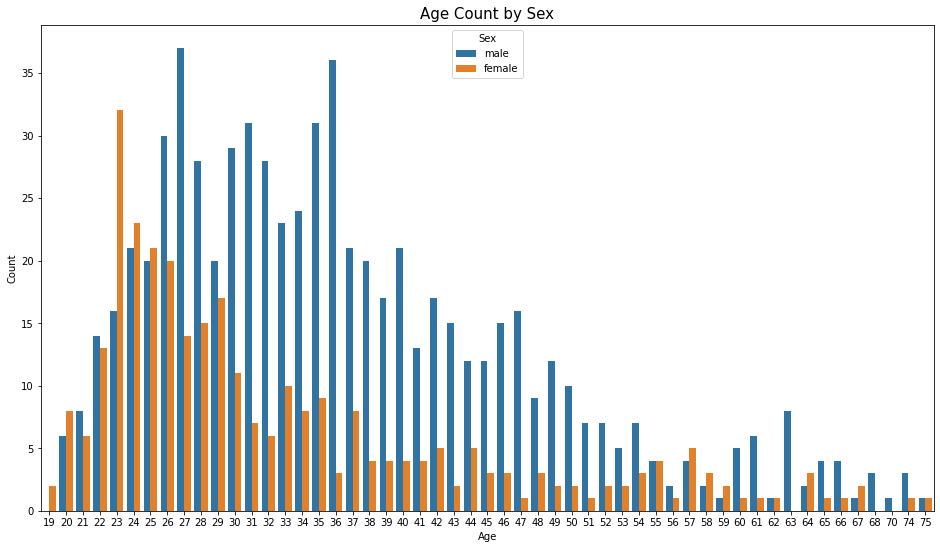

In [ ]:
# todo
df_male = df_credit[df_credit["Sex"] == '']
# todo
df_female = df_credit[df_credit["Sex"] == '']

fig, ax = plt.subplots(nrows=1, figsize=(16,10))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

g2 = sns.countplot(x="Age", data=df_credit, hue = "Sex")
g2.set_title("Age Count by Sex", fontsize=15)
g2.set_xlabel("Age")
g2.set_ylabel("Count")
plt.show()

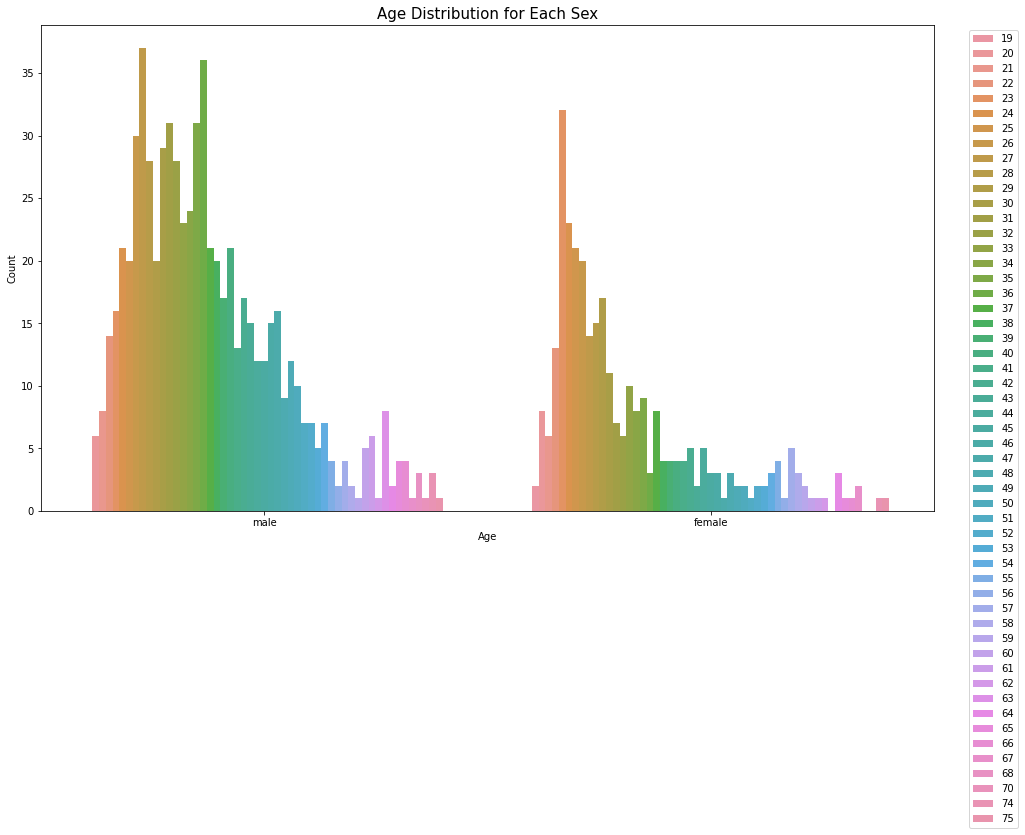

In [ ]:
df_age = df_credit["Age"]

fig, ax = plt.subplots(nrows=1, figsize=(16,10))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

g2 = sns.countplot(x="Sex", data=df_credit, hue = "Age")
g2.set_title("Age Distribution for Each Sex", fontsize=15)
g2.set_xlabel("Age")
g2.set_ylabel("Count")
g2.legend(loc="upper right",bbox_to_anchor=(1.1, 1),)
plt.show()

## Data Preprocessing

In [ ]:
#  Fill Missing Values
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

#  Make age into buckets
interval = (18, 25, 35, 60, 120)
cats = ['Student', 'Young', 'Adult', 'Senior']
df_credit["Age_cat"] = pd.cut(df_credit.Age, interval, labels=cats)
del df_credit['Age']

#  Convert Categoricals into columns
categorical_columns = [('Purpose','Purpose'),('Sex','Sex'),('Housing','Housing'),
                       ('Saving accounts','Saving'),('Checking account','Checking'),
                      ('Age_cat','Age_Cat')]

for c in categorical_columns:
    df_credit = df_credit.merge(
                    pd.get_dummies(df_credit[c[0]], drop_first=True,prefix=c[1]),
                    left_index=True,
                    right_index=True
    )
    del df_credit[c[0]]

#  Risk needs special handling
df_credit = df_credit.merge(pd.get_dummies(df_credit.Risk, prefix='Risk'), left_index=True, right_index=True)
del df_credit['Risk']

# not interested in this column for this assignment
del df_credit['Risk_good']
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Job                          1000 non-null   int64
 1   Credit amount                1000 non-null   int64
 2   Duration                     1000 non-null   int64
 3   Purpose_car                  1000 non-null   uint8
 4   Purpose_domestic appliances  1000 non-null   uint8
 5   Purpose_education            1000 non-null   uint8
 6   Purpose_furniture/equipment  1000 non-null   uint8
 7   Purpose_radio/TV             1000 non-null   uint8
 8   Purpose_repairs              1000 non-null   uint8
 9   Purpose_vacation/others      1000 non-null   uint8
 10  Sex_male                     1000 non-null   uint8
 11  Housing_own                  1000 non-null   uint8
 12  Housing_rent                 1000 non-null   uint8
 13  Saving_moderate              1000 non-null   uint

## Task 1: Training Model

### Random Forest Classifier

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score, recall_score,precision_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay

In [ ]:
y = df_credit["Risk_bad"]
X = df_credit.drop('Risk_bad', 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=69)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
rf = RandomForestClassifier(max_depth=None, max_features=10, n_estimators=15, random_state=420)
# todo
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=10, n_estimators=15, random_state=420)

In [ ]:
# todo
y_pred = rf.predict(X_test)
print("Accuracy:",str(accuracy_score(y_test,y_pred)))

Accuracy: 0.712


In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[147  35]
 [ 37  31]]


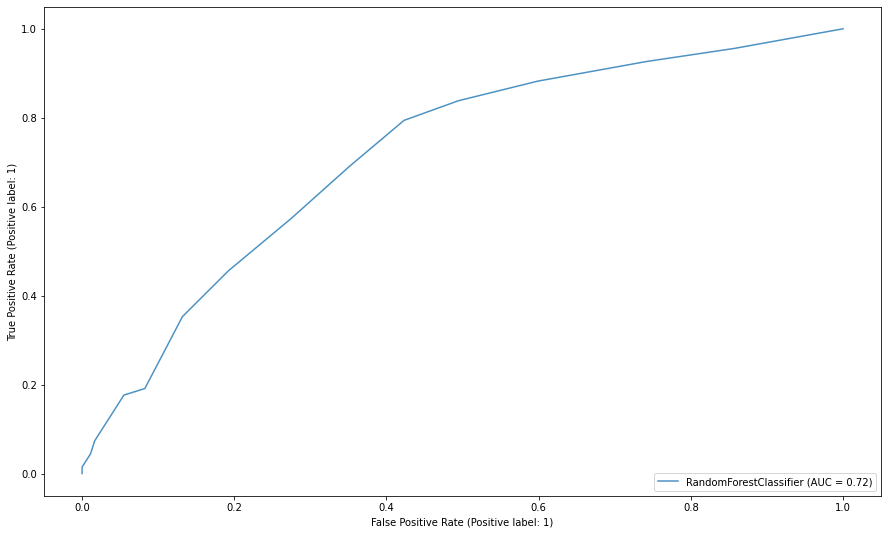

In [ ]:
plt.figure(figsize=((15,9)))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

## Task 2: Measuring Fairness

### Anti-Classification - Gender


In [ ]:
print("Original test set length")
print(len(X_test))

Original test set length
250


In [ ]:
males=X_test.copy()
# todo - we want a dataframe where gender is set to male for all rows
males=males.assign(Sex_male=1)
print('All values of Sex_male in test dataset after considering gender is male: ',males['Sex_male'].unique())
print('Length test dataset after considering gender is male:', len(males))

All values of Sex_male in test dataset after considering gender is male:  [1]
Length test dataset after considering gender is male: 250


In [ ]:
females=X_test.copy()
# todo - we want a dataframe where gender is set to female for all rows
females=females.assign(Sex_male=0)
print('All values of Sex_male in test dataset after considering gender is female: ',females['Sex_male'].unique())
print('Length test dataset after considering gender is female:', len(males))

All values of Sex_male in test dataset after considering gender is female:  [0]
Length test dataset after considering gender is female: 250


In [ ]:
males_pred=rf.predict(males)
females_pred=rf.predict(females)

In [ ]:
print("Accuracy when gender is considered male")
print(accuracy_score(y_test, males_pred))
print("Accuracy when gender is considered female")
print(accuracy_score(y_test, females_pred))

Accuracy when gender is considered male
0.716
Accuracy when gender is considered female
0.704


In [ ]:
flipped_gender=X_test.copy()
flipped_gender['Sex_male']=flipped_gender['Sex_male'].replace({0:1, 1:0})

In [ ]:
original_pred=rf.predict(X_test)
flipped_gender_pred=rf.predict(flipped_gender)
print("Accuracy of Original predictions")
print(accuracy_score(y_test, original_pred))
print("Accuracy when Gender is flipped")
print(accuracy_score(y_test,flipped_gender_pred))

Accuracy of Original predictions
0.712
Accuracy when Gender is flipped
0.708


In [ ]:
print("Confusion Matrix when gender is considered male")
print(confusion_matrix(y_test, males_pred))
print("\nConfusion Matrix when gender is considered female")
print(confusion_matrix(y_test, females_pred))
print("\nConfusion Matrix of original predictions")
print(confusion_matrix(y_test, original_pred))
print("\nConfusion Matrix when gender is flipped")
print(confusion_matrix(y_test, flipped_gender_pred))

Confusion Matrix when gender is considered male
[[150  32]
 [ 39  29]]

Confusion Matrix when gender is considered female
[[143  39]
 [ 35  33]]

Confusion Matrix of original predictions
[[147  35]
 [ 37  31]]

Confusion Matrix when gender is flipped
[[146  36]
 [ 37  31]]


ROC curve when gender is considered male


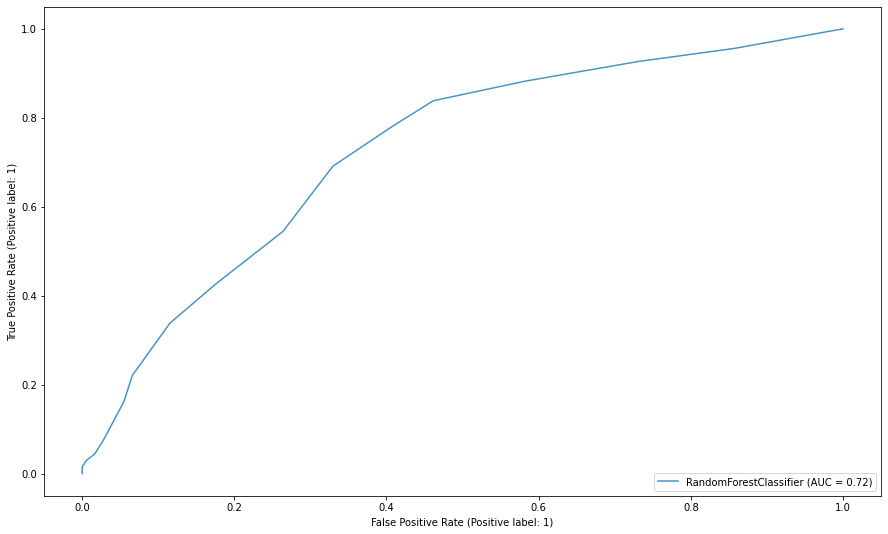

In [ ]:
print('ROC curve when gender is considered male')
plt.figure(figsize=((15,9)))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf, males, y_test, ax=ax, alpha=0.8)
plt.show()

ROC curve when gender is considered female


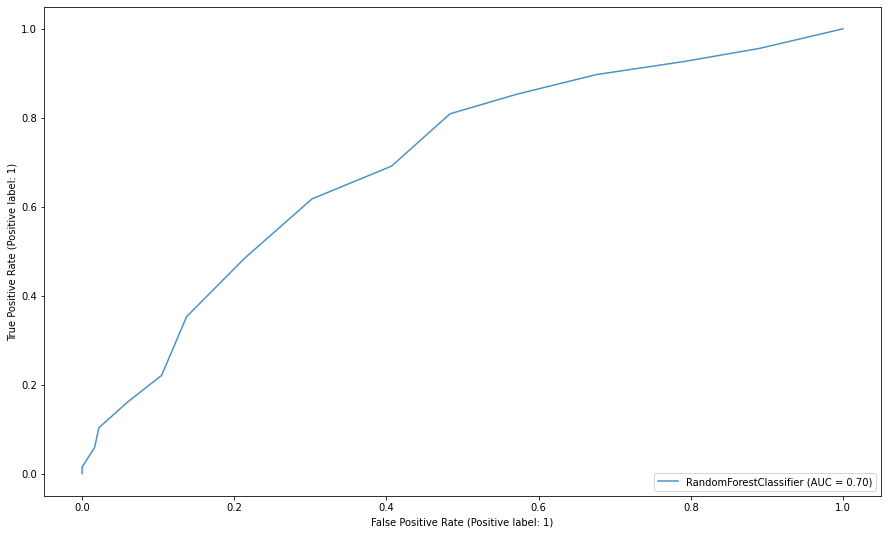

In [ ]:
print('ROC curve when gender is considered female')
plt.figure(figsize=((15,9)))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf, females, y_test, ax=ax, alpha=0.8)
plt.show()

ROC curve when gender is flipped


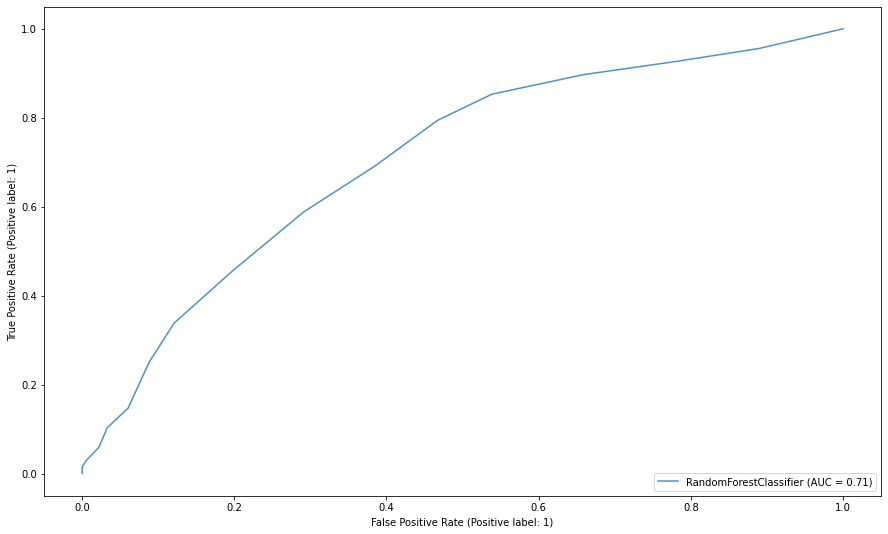

In [ ]:
print('ROC curve when gender is flipped')
plt.figure(figsize=((15,9)))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf, flipped_gender, y_test, ax=ax, alpha=0.8)
plt.show()

In [ ]:
print("Total length of predictions: ",len(y_pred))
print("Number of same predictions between when gender is considered male and female and predicted seperately: " , sum(males_pred==females_pred))

Total length of predictions:  250
Number of same predictions between when gender is considered male and female and predicted seperately:  217


In [ ]:
print("Total length of predictions: ",len(y_pred))
print("Number of same predictions between original predictions and when when gender is flipped: " , sum(flipped_gender_pred==y_pred))

Total length of predictions:  250
Number of same predictions between original predictions and when when gender is flipped:  217


### Independence - Gender

In [ ]:
df_credit.columns

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior', 'Risk_bad'],
      dtype='object')

In [ ]:
print("Original test set length")
print(len(X_test))

Original test set length
250


In [ ]:
males=X_test[X_test["Sex_male"]==1]
females=X_test[X_test["Sex_male"]==0]

In [ ]:
print("Number of males in test set: ",len(males))
print("Number of females in test set: ",len(females))
males_pred = rf.predict(males)
females_pred = rf.predict(females)

Number of males in test set:  182
Number of females in test set:  68


In [ ]:
print("Probability of Y==1 given gender is male: ", sum(males_pred)/len(males_pred))
print("Probability of Y==1 given gender is female: ", sum(females_pred)/len(females_pred))

Probability of Y==1 given gender is male:  0.22527472527472528
Probability of Y==1 given gender is female:  0.36764705882352944


### Separation - Gender

In [ ]:
df_credit.columns

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior', 'Risk_bad'],
      dtype='object')

In [ ]:
print("Original test set length")
print(len(X_test))

Original test set length
250


In [ ]:
test_with_labels=X_test.copy()
test_with_labels=test_with_labels.assign(Risk_bad=y_test)
test_with_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 823 to 441
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Job                          250 non-null    int64
 1   Credit amount                250 non-null    int64
 2   Duration                     250 non-null    int64
 3   Purpose_car                  250 non-null    uint8
 4   Purpose_domestic appliances  250 non-null    uint8
 5   Purpose_education            250 non-null    uint8
 6   Purpose_furniture/equipment  250 non-null    uint8
 7   Purpose_radio/TV             250 non-null    uint8
 8   Purpose_repairs              250 non-null    uint8
 9   Purpose_vacation/others      250 non-null    uint8
 10  Sex_male                     250 non-null    uint8
 11  Housing_own                  250 non-null    uint8
 12  Housing_rent                 250 non-null    uint8
 13  Saving_moderate              250 non-null    uin

In [ ]:
males=test_with_labels[test_with_labels["Sex_male"]==1]
females=test_with_labels[test_with_labels["Sex_male"]==0]

In [ ]:
print("Number of males in test set: ",len(males))
print("Number of females in test set: ",len(females))

Number of males in test set:  182
Number of females in test set:  68


In [ ]:
males_labels=males['Risk_bad']
females_labels=females['Risk_bad']
males=males.drop('Risk_bad', 1)
females=females.drop("Risk_bad",1)
print(males.columns)
print(females.columns)

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior'],
      dtype='object')
Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [ ]:
males_pred=rf.predict(males)
females_pred=rf.predict(females)

In [ ]:
males_matrix=confusion_matrix(males_labels, males_pred)
print("Confusion Matrix for males:")
print(males_matrix)
print("\nFalse Positive Rate for males: ", males_matrix[0][1]/(males_matrix[0][1]+males_matrix[1][1]))
print("False Negative Rate for males: ", males_matrix[1][0]/(males_matrix[1][0]+males_matrix[0][0]))
print("\nPrecision Score for males: ", precision_score(males_labels, males_pred))
print("Recall Score for males: ", recall_score(males_labels, males_pred))
print("F1 Score for males: ", f1_score(males_labels, males_pred))

Confusion Matrix for males:
[[111  22]
 [ 30  19]]

False Positive Rate for males:  0.5365853658536586
False Negative Rate for males:  0.2127659574468085

Precision Score for males:  0.4634146341463415
Recall Score for males:  0.3877551020408163
F1 Score for males:  0.4222222222222223


In [ ]:
females_matrix=confusion_matrix(females_labels, females_pred)
print("Confusion Matrix for females:")
print(females_matrix)
print("\nFalse Positive Rate for females: ", females_matrix[0][1]/(females_matrix[0][1]+females_matrix[1][1]))
print("False Negative Rate for females: ", females_matrix[1][0]/(females_matrix[1][0]+females_matrix[0][0]))
print("\nPrecision Score for females: ", precision_score(females_labels, females_pred))
print("Recall Score for females: ", recall_score(females_labels, females_pred))
print("F1 Score for females: ", f1_score(females_labels, females_pred))

Confusion Matrix for females:
[[36 13]
 [ 7 12]]

False Positive Rate for females:  0.52
False Negative Rate for females:  0.16279069767441862

Precision Score for females:  0.48
Recall Score for females:  0.631578947368421
F1 Score for females:  0.5454545454545454


## Task 3: Improve model fairness

### Anti-Classification - Gender
For anti-classification we will make the model blind to the "gender" protected attribute. For this we will drop the "Sex_male" variable from our data and train a new classification model.

In [ ]:
X_train_3a=X_train.copy()
X_test_3a=X_test.copy()

In [ ]:
print(X_train_3a.columns)
print(X_test_3a.columns)

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior'],
      dtype='object')
Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior'],
      dtype='object')


In [ ]:
X_train_3a=X_train_3a.drop("Sex_male",1)
X_test_3a=X_test_3a.drop("Sex_male",1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
rf_3a=RandomForestClassifier(max_depth=None, max_features=10, n_estimators=15, random_state=2)
rf_3a.fit(X_train_3a,y_train)

RandomForestClassifier(max_features=10, n_estimators=15, random_state=2)

In [ ]:
pred_3a=rf_3a.predict(X_test_3a)

In [ ]:
print('Original Accuracy of model:', accuracy_score(y_test,y_pred))
print('Accuracy of fairer model:', accuracy_score(y_test,pred_3a))

Original Accuracy of model: 0.712
Accuracy of fairer model: 0.712


In [ ]:
print("Confusion Matrix of original model:\n", confusion_matrix(y_test, y_pred))
print("Confusion Matrix of fairer model:\n", confusion_matrix(y_test, pred_3a))

Confusion Matrix of original model:
 [[147  35]
 [ 37  31]]
Confusion Matrix of fairer model:
 [[146  36]
 [ 36  32]]


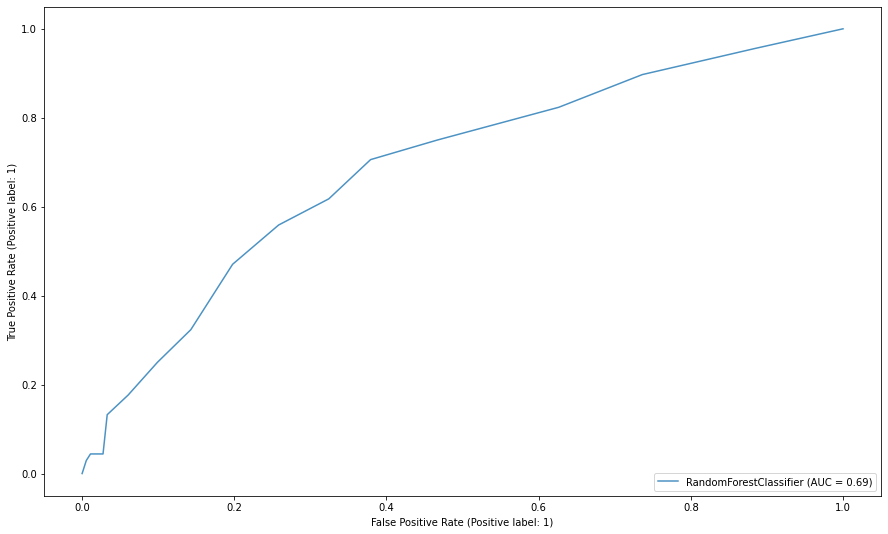

In [ ]:
plt.figure(figsize=((15,9)))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf_3a, X_test_3a, y_test, ax=ax, alpha=0.8)
plt.show()

### Independence - Gender
We will use predict_proba and change the threshold for classification. Since we saw that females had a higher probability of Y==1 (getting the label as high risk) we will reduce the threshold for Sex_male=0

In [ ]:
males=X_test[X_test["Sex_male"]==1]
females=X_test[X_test["Sex_male"]==0]

In [ ]:
print("Number of males in test set: ",len(males))
print("Number of females in test set: ",len(females))
males_pred_proba = rf.predict_proba(males)
females_pred_proba = rf.predict_proba(females)

Number of males in test set:  182
Number of females in test set:  68


In [ ]:
males_pred = males_pred_proba[:,0] < 0.5
females_pred = females_pred_proba[:,0] < 0.45

In [ ]:
print("Probability of Y==1 given gender is male: ", sum(males_pred)/len(males_pred))
print("Probability of Y==1 given gender is female: ", sum(females_pred)/len(females_pred))

Probability of Y==1 given gender is male:  0.22527472527472528
Probability of Y==1 given gender is female:  0.25


In [ ]:
male_accuracy=accuracy_score(males_labels,males_pred)
female_accuracy=accuracy_score(females_labels,females_pred)
print("Accuracy for males: ",male_accuracy)
print("Accuracy for females: ",female_accuracy)

print('Original model accuracy:', accuracy_score(y_test,y_pred))
fair_model_accuracy=(len(males_labels)*male_accuracy +len(females_labels)*female_accuracy)/len(y_test)
print("Fairer model accuracy: ", fair_model_accuracy)

Accuracy for males:  0.7142857142857143
Accuracy for females:  0.7058823529411765
Original model accuracy: 0.712
Fairer model accuracy:  0.712


In [ ]:
print("Confusion Matrix for males:\n", confusion_matrix(males_labels,males_pred))
print("\nConfusion Matrix for females:\n", confusion_matrix(females_labels,females_pred))

Confusion Matrix for males:
 [[111  22]
 [ 30  19]]

Confusion Matrix for females:
 [[40  9]
 [11  8]]


### Separation - Gender
We will employ a similar staregy as the last independence and alter the thresholds. For gender we see that the males have a higher False negative rate (Y==0) than females. This is consistent with out previous finding that females are predicted to be at higher risk than males. Hence here we can either decrease the threshold for females or increase the threshold for males. We reduce the threshold for females.

In [ ]:
males=X_test[X_test["Sex_male"]==1]
females=X_test[X_test["Sex_male"]==0]

In [ ]:
print("Number of males in test set: ",len(males))
print("Number of females in test set: ",len(females))
males_pred_proba = rf.predict_proba(males)
females_pred_proba = rf.predict_proba(females)

Number of males in test set:  182
Number of females in test set:  68


In [ ]:
males_pred = males_pred_proba[:,0] < 0.5
females_pred = females_pred_proba[:,0] < 0.45

In [ ]:
males_matrix=confusion_matrix(males_labels, males_pred)
print("Confusion Matrix for males:")
print(males_matrix)
print("\nFalse Positive Rate for males: ", males_matrix[0][1]/(males_matrix[0][1]+males_matrix[1][1]))
print("False Negative Rate for males: ", males_matrix[1][0]/(males_matrix[1][0]+males_matrix[0][0]))
print("\nPrecision Score for males: ", precision_score(males_labels, males_pred))
print("Recall Score for males: ", recall_score(males_labels, males_pred))
print("F1 Score for males: ", f1_score(males_labels, males_pred))

Confusion Matrix for males:
[[111  22]
 [ 30  19]]

False Positive Rate for males:  0.5365853658536586
False Negative Rate for males:  0.2127659574468085

Precision Score for males:  0.4634146341463415
Recall Score for males:  0.3877551020408163
F1 Score for males:  0.4222222222222223


In [ ]:
females_matrix=confusion_matrix(females_labels, females_pred)
print("Confusion Matrix for females:")
print(females_matrix)
print("\nFalse Positive Rate for females: ", females_matrix[0][1]/(females_matrix[0][1]+females_matrix[1][1]))
print("False Negative Rate for females: ", females_matrix[1][0]/(females_matrix[1][0]+females_matrix[0][0]))
print("\nPrecision Score for females: ", precision_score(females_labels, females_pred))
print("Recall Score for females: ", recall_score(females_labels, females_pred))
print("F1 Score for females: ", f1_score(females_labels, females_pred))

Confusion Matrix for females:
[[40  9]
 [11  8]]

False Positive Rate for females:  0.5294117647058824
False Negative Rate for females:  0.21568627450980393

Precision Score for females:  0.47058823529411764
Recall Score for females:  0.42105263157894735
F1 Score for females:  0.4444444444444444


Now we can see that we are getting almost similar True positive rate and false positive rate for males and females.While this model is fair, the overall FNR has increase. So,now instead of increasing the FNR of females we will try to reduce the FNR of males.

In [ ]:
males_pred = males_pred_proba[:,0] < 0.65
females_pred = females_pred_proba[:,0] < 0.5

In [ ]:
males_matrix=confusion_matrix(males_labels, males_pred)
print("Confusion Matrix for males:")
print(males_matrix)
print("\nFalse Positive Rate for males: ", males_matrix[0][1]/(males_matrix[0][1]+males_matrix[1][1]))
print("False Negative Rate for males: ", males_matrix[1][0]/(males_matrix[1][0]+males_matrix[0][0]))
print("\nPrecision Score for males: ", precision_score(males_labels, males_pred))
print("Recall Score for males: ", recall_score(males_labels, males_pred))
print("F1 Score for males: ", f1_score(males_labels, males_pred))

Confusion Matrix for males:
[[90 43]
 [17 32]]

False Positive Rate for males:  0.5733333333333334
False Negative Rate for males:  0.1588785046728972

Precision Score for males:  0.4266666666666667
Recall Score for males:  0.6530612244897959
F1 Score for males:  0.5161290322580645


In [ ]:
females_matrix=confusion_matrix(females_labels, females_pred)
print("Confusion Matrix for females:")
print(females_matrix)
print("\nFalse Positive Rate for females: ", females_matrix[0][1]/(females_matrix[0][1]+females_matrix[1][1]))
print("False Negative Rate for females: ", females_matrix[1][0]/(females_matrix[1][0]+females_matrix[0][0]))
print("\nPrecision Score for females: ", precision_score(females_labels, females_pred))
print("Recall Score for females: ", recall_score(females_labels, females_pred))
print("F1 Score for females: ", f1_score(females_labels, females_pred))

Confusion Matrix for females:
[[36 13]
 [ 7 12]]

False Positive Rate for females:  0.52
False Negative Rate for females:  0.16279069767441862

Precision Score for females:  0.48
Recall Score for females:  0.631578947368421
F1 Score for females:  0.5454545454545454


We see now that the FNR for males and females is almost same but the FPR rate for males is higher. This is a less fair model but might be more helpful as there are less false negatives (people being deemed high risk when they are not).

### Using IBM's AIF 360 
This extensible open source toolkit can help you examine, report, and mitigate discrimination and bias in machine learning models throughout the AI application lifecycle.
To use this demo, please download the following files:

	https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
	https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc

and place them, as-is, in the folder:

	/usr/local/lib/python3.7/dist-packages/aif360/data/raw/german

In [ ]:
# Load all necessary packages
import sys
sys.path.insert(1, "../")  
import numpy as np
np.random.seed(0)

from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

In [ ]:
dataset_orig = GermanDataset(
    protected_attribute_names=['age'],           # this dataset also contains protected
                                                 # attribute for "sex" which we do not
                                                 # consider in this evaluation
    privileged_classes=[lambda x: x >= 25],      # age >=25 is considered privileged
    features_to_drop=['personal_status', 'sex'] # ignore sex-related attributes
)

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())


Difference in mean outcomes between unprivileged and privileged groups = -0.169905


Step 4 Mitigate bias by transforming the original dataset


In [ ]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

Compute fairness metric on transformed dataset

In [ ]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())


Difference in mean outcomes between unprivileged and privileged groups = 0.000000
